In [1]:
# Need to load a project token so the vector file can be loaded from the object store
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='35c0b981-e7f7-4cad-86e4-9a8bd67b8139', project_access_token='p-8df3c41caffb132c9b16605d072fee8c7952a1dd')
pc = project.project_context


#Code to load a ".gz" file This is currently ignored
#skip_file = project.get_file("GoogleNews-vectors-negative300.bin.gz")
skip_file = project.get_file("ap_news_skipgram_300.bin")

# import gzip

# gzip_f = gzip.GzipFile(fileobj=skip_file)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190415143617-0000
KERNEL_ID = 126e827f-17c0-4769-94fe-b5d9cc31f833


In [2]:
!pip install gensim

    100% |################################| 24.2MB 801kB/s eta 0:00:01
    100% |################################| 51kB 1.4MB/s eta 0:00:01
    100% |################################| 17.2MB 952kB/s eta 0:00:01
    100% |################################| 24.7MB 577kB/s eta 0:00:01
    100% |################################| 1.4MB 1.9MB/s eta 0:00:01
    100% |################################| 61kB 2.1MB/s eta 0:00:01
    100% |################################| 133kB 3.1MB/s eta 0:00:01
    100% |################################| 122kB 3.0MB/s eta 0:00:01
    100% |################################| 143kB 3.2MB/s eta 0:00:01
    100% |################################| 61kB 1.9MB/s eta 0:00:01
    100% |################################| 163kB 3.0MB/s eta 0:00:01
    100% |################################| 5.4MB 1.6MB/s eta 0:00:01
    100% |################################| 71kB 1.9MB/s eta 0:00:01
    100% |################################| 235kB 3.8MB/s eta 0:00:01
    100% |###########

In [4]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim, nltk, re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

%matplotlib inline

### May need to download the stopwords and punkt

In [5]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Unzipping tokenizers/punkt.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [6]:
# Set up cleaning criteria to be used in the text cleaning phase
stop_w = set(stopwords.words('english'))
chars = re.compile('[/(){}\[\]\|@,;!$&-]')
symbl = re.compile('[^0-9a-z #+_]')

In [7]:
def print_one_item(df, itm):
    prt = df[df.index == itm][['post', 'tags']].values[0]
    if len(prt) > 0:
        print(prt[0])
        print('Tag:', prt[1])
        print('Length:', len(prt[0]))

def clean_text(inp_text):
# Use BeautifulSoup to remove HTML encoding - not the best but pretty close and very fast    
    inp_text = BeautifulSoup(inp_text, "lxml").text
    
    # convert to lower case, this will help in the next steps
    inp_text = inp_text.lower()
    
    # remove stop words
    inp_text = ' '.join(word for word in inp_text.split() if word not in stop_w)
    
    # remove special characters
    inp_text = chars.sub(' ', inp_text)
    
    # remove symbols
    inp_text = symbl.sub('', inp_text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    return inp_text        

In [8]:
# Use the project token to load the CSV data file
my_data_file = project.get_file("cognet_articles.csv")

df_inprt = pd.read_csv(my_data_file)

# Make sure the articles we use have tags
df_inprt = df_inprt[pd.notnull(df_inprt['Keyword'])]

df_temp = df_inprt[['Body','Keyword']]
    
df_temp.rename(columns={'Body':'post','Keyword':'tags'},inplace=True)

df_temp.head(10)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,post,tags
0,How to Vacation Like a Celebrity on a Shoestri...,competitive
1,There are no Videos in your queue. Click on th...,competitive
2,Plenty happening on the basketball front but t...,competitive
3,Top 5 landing spots for former Seattle Seahawk...,competitive
4,When video watchers hear Netflix is behind a m...,competitive
5,SAN JOSE Calif. March 13 2018 (GLOBE NEWSWIRE)...,competitive
6,With another Major victory under their belt Vi...,competitive
7,With 294 Grand Prix races won between 1987 and...,competitive
8,American lightweight Nick Newell returned from...,competitive
9,Ola on Monday launched its operations in Sydne...,competitive


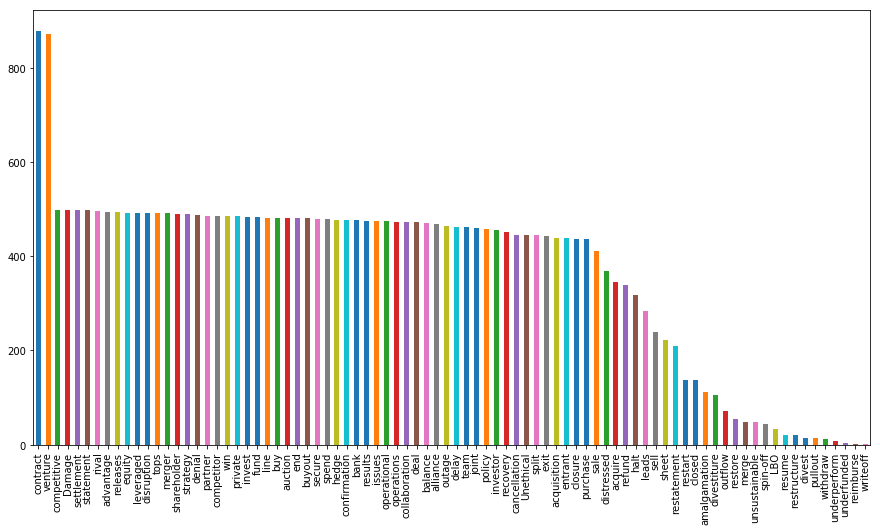

In [9]:
# make a chart of the tags beofre we drop some
plt.figure(figsize=(15,8))
temp_cnt = df_temp.tags.value_counts()
temp_cnt.plot(kind='bar');

# Tag processing

Drop tags with less than 150 articles. This should result in 64 tags to use in the model

In [11]:
tag_list = df_temp.groupby(['tags']).size().reset_index(name='count')
tags_work = tag_list.loc[tag_list['count'] > 150]
tags_work

,tags,count
0,Damage,499
2,Unethical,445
3,acquire,346
4,acquisition,439
5,advantage,494
6,alliance,468
8,auction,481
9,balance,471
10,bank,476
11,buy,482


Cut down the article list to just those with tags we want to keep

In [12]:
# how many rows in the temp dataset
temp_t, c = df_temp.shape

# filter into a working DF based on the tags in the working tag set
df_work = df_temp.loc[df_temp['tags'].isin(tags_work['tags'])]

# how many rows in the temp dataset
temp_w, c = df_work.shape

print ("%6d Rows dropped" % (temp_t-temp_w))

   888 Rows dropped


In [13]:
# Check the word counts
words_t = df_temp['post'].apply(lambda x: len(x.split(' '))).sum()
words_w = df_work['post'].apply(lambda x: len(x.split(' '))).sum()

print("Started with {:,} words, {:,} words remain, ({:,} fewer words)".format(words_t, words_w,words_t-words_w))

Started with 11,303,169 words, 10,892,995 words remain, (410,174 fewer words)


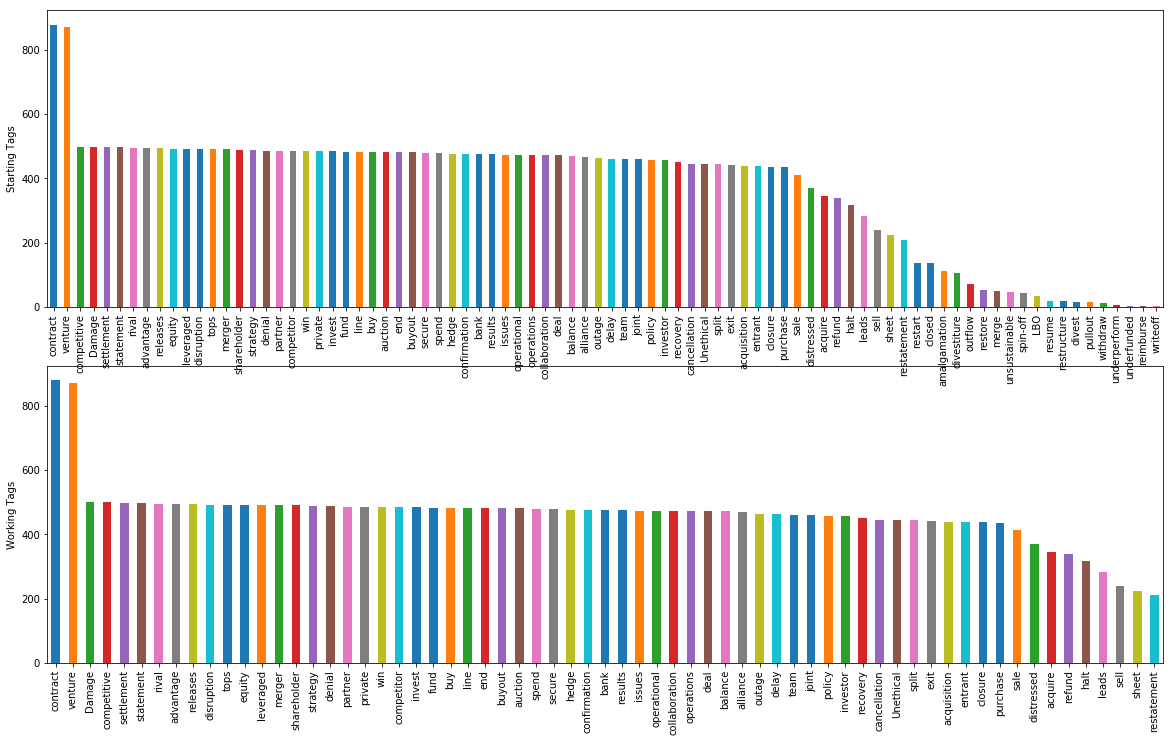

In [14]:
# make a chart of the tags now that we have fewer
# Compare the starting set to the working set

work_cnt = df_work.tags.value_counts()
temp_cnt = df_temp.tags.value_counts()

plt.figure(1,figsize=(20,12))

plt.subplot(212)
work_cnt.plot(kind='bar')
plt.ylabel("Working Tags")

plt.subplot(211)
temp_cnt.plot(kind='bar')
plt.ylabel("Starting Tags")

#plt.xlabel('Tag')

plt.show()


# Text Cleanup

Commas were removed in the pre-processing step 
This was done so the reulting data could be transfered via CSV

Now we need to remove:
- Special characters
- Special symbols
- Stopwords

In [15]:
df_work['post'] = df_work['post'].apply(clean_text)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Review some of the data, just so we can see it

In [16]:
# Original
print_one_item(df_temp, 36)

DUBLIN--(BUSINESS WIRE)--The "Saudi Arabia 50 Hp and Above Electric Motor Market (2018-2024): Market Forecast by Type by Voltage by End Users by Service Types by Applications by Regions and Competitive Landscape" report has been added to ResearchAndMarkets.com's offering. Saudi Arabia 50 Hp and above electric motor market revenues are projected to grow at a CAGR of 5.8% during 2018-24. Expansion of non-oil sector by boosting investments in private sector is one of the main objectives of the current Saudi Arabian government. Development of public infrastructure as well as government policies to support establishment of new industries and large scale investments in the power and water utility sectors are the key drivers for the growth of above 50 Hp electric motor market in Saudi Arabia. However the market volume declined in 2016 due to lower government spending as a result of budget deficit due to low crude oil prices. The market has declined in 2016 and 2017 due to reduced government s

In [17]:
# New
print_one_item(df_work, 36)

dublin   business wire   the saudi arabia 50 hp electric motor market  2018 2024  market forecast type voltage end users service types applications regions competitive landscape report added researchandmarketscoms offering saudi arabia 50 hp electric motor market revenues projected grow cagr 58 2018 24 expansion non oil sector boosting investments private sector one main objectives current saudi arabian government development public infrastructure well government policies support establishment new industries large scale investments power water utility sectors key drivers growth 50 hp electric motor market saudi arabia however market volume declined 2016 due lower government spending result budget deficit due low crude oil prices market declined 2016 2017 due reduced government spending result low crude oil prices however market likely recover post 2017 due expected recovery global crude oil prices changing government policies establishment special economic zones expansion automotive ma

## Create X and Y sets, then split them 70/30

In [18]:
X = df_work.post
y = df_work.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 64)

- Convert documents to a matrix of token counts (CountVectorizer)
- Transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
- Use a relatively simple Naive Bayes classifier as our starting point so we have something to compare to

### Naive Bayes classifier

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### precision
    Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”
### recall
    Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”
### f1 score
    The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
### support
    Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
###### (https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html)

In [20]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('Overall accuracy %6.4s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=tags_work['tags']))

Overall accuracy   0.36
               precision    recall  f1-score   support

       Damage       0.63      0.63      0.63       155
    Unethical       0.66      0.65      0.66       133
      acquire       0.33      0.30      0.31       120
  acquisition       1.00      0.04      0.08       141
    advantage       0.61      0.31      0.41       141
     alliance       1.00      0.09      0.17       144
      auction       0.86      0.66      0.75       145
      balance       0.23      0.74      0.36       117
         bank       0.91      0.13      0.23       151
          buy       0.70      0.63      0.67       123
       buyout       0.76      0.24      0.36       161
 cancellation       0.78      0.43      0.55       145
      closure       0.76      0.40      0.53       112
collaboration       1.00      0.07      0.13       132
  competitive       0.29      0.32      0.30       142
   competitor       0.90      0.18      0.30       151
 confirmation       1.00      0.26      

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Load Word2vec and run as a logistic regression classifier

In [21]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format(skip_file, binary=True)
wv.init_sims(replace=True)

CPU times: user 34.9 s, sys: 456 ms, total: 35.3 s
Wall time: 35.4 s


In [22]:
def word_averaging(wv, words):
    all_words = set()
    mean = []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [23]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [24]:
train, test = train_test_split(df_work, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [25]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).


In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [27]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=tags_work['tags']))

accuracy 0.526181777925
               precision    recall  f1-score   support

       Damage       0.66      0.66      0.66       135
    Unethical       0.60      0.73      0.66       135
      acquire       0.48      0.51      0.50       121
  acquisition       0.34      0.42      0.37       116
    advantage       0.58      0.64      0.60       159
     alliance       0.48      0.51      0.49       126
      auction       0.68      0.84      0.75       158
      balance       0.51      0.54      0.53       137
         bank       0.32      0.24      0.27       147
          buy       0.66      0.68      0.67       136
       buyout       0.46      0.46      0.46       134
 cancellation       0.54      0.62      0.58       128
      closure       0.59      0.50      0.54       123
collaboration       0.61      0.61      0.61       137
  competitive       0.41      0.39      0.40       152
   competitor       0.44      0.42      0.43       145
 confirmation       0.55      0.55      

### Build a neural network classifier with keras

In [33]:
import itertools
import os

# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [34]:
# Start with a new train/test split, same 70/30 as before

train_posts, test_posts, train_tags, test_tags = train_test_split(df_work.post, df_work.tags, random_state=0, test_size=0.3)

print ("Train size: %d" % len(train_posts))
print ("Test  size: %d" % len(test_posts))

Train size: 21077
Test  size: 9033


In [35]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [36]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [37]:
# Run the encode on the Y values (tags)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [38]:
# Define the number of output classes
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [39]:
batch_size = 64  # 32
epochs = 6      #  6

In [40]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))   #0.5
# model.add(Dense(num_classes))
# model.add(Dropout(0.2))   #0.5
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy',         # tested - accuracy was 0.63 - 0,66
#               optimizer='adam',
#               metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                33345     
_________________________________________________________________
activation_2 (Activation)    (None, 65)                0         
Total params: 545,857
Trainable params: 545,857
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 18969 samples, validate on 2108 samples
Epoch 1/6
18969/18969 [==============================] - 4s 190us/step - loss: 0.0576 - acc: 0.9855 - val_loss: 0.0399 - val_acc: 0.9875
Epoch 2/6
18969/18969 [==============================] - 3s 182us/step - loss: 0.0338 - acc: 0.9889 - val_loss: 0.0307 - val_acc: 0.9897
Epoch 3/6
18969/18969 [==============================] - 3s 180us/step - loss: 0.0251 - acc: 0.9914 - val_loss: 0.0288 - val_acc: 0.9902
Epoch 4/6
18969/18969 [==============================] - 3s 184us/step - loss: 0.0201 - acc: 0.9931 - val_loss: 0.0276 - val_acc: 0.9905
Epoch 5/6
18969/18969 [==============================] - 3s 180us/step - loss: 0.0166 - acc: 0.9943 - val_loss: 0.0273 - val_acc: 0.9908
Epoch 6/6
18969/18969 [==============================] - 3s 181us/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.0280 - val_acc: 0.9906


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])